<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

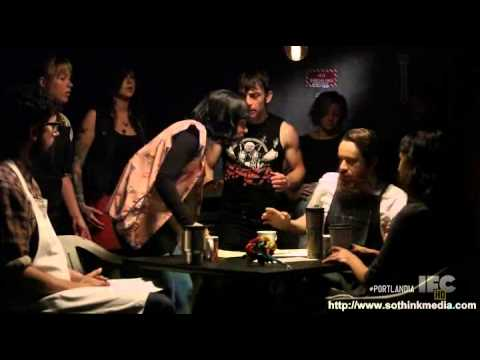

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/johnnykoo/codestates/course/data/lambda/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [5]:
data_dir = %pwd
print(data_dir)

/Users/johnnykoo/codestates/course/data/lambda/DS-Unit-4-Sprint-1-NLP/module1-text-data


In [6]:
import pandas as pd

# url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"
url = data_dir + "/data/yelp_coffeeshop_review_data.csv"
shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [2]:
# Start here 

In [10]:
pd.options.display.max_colwidth

50

In [15]:
pd.options.display.max_colwidth = 500

In [8]:
shops.shape

(7616, 3)

In [16]:
shops.iloc[1]

coffee_shop_name                                                                                                                                                                                                                                                                                          The Factory - Cafe With a Soul 
full_review_text     12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-worthy!!!  Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) Waffle dessert was just decent...nothing to rave about.  But, will probably be back just to be somewhere unique and nice. 
star_rating                                                                                                                                                                                                                                                                                                              4.0 star rating 
Name: 1, d

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [22]:
# test removal extra strings in star_rating
x = shops['star_rating'][0]
result = float(x.split()[0])


float

In [23]:
def clean_star(words):
    return float(words.split()[0])

In [24]:
# clean
shops['star_rating'] = shops['star_rating'].apply(clean_star)
shops['star_rating'].head()

0    5.0
1    4.0
2    4.0
3    2.0
4    4.0
Name: star_rating, dtype: float64

In [31]:
# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [30]:
shops['full_review_text'].value_counts(normalize=True)[:50]

 10/10/2016 This place is so cute. New favorite coffee spot on Burnet/in Northcross. Almost wish I was still in grad school,  so I would have an excuse to be there everyday.  Amazing coffee and best chicken & waffles ever! The chicken was seasoned perfectly and made for a delicious savory brunch (with the house made slaw they give you on the side). The olive oil cake was also awesome, light and sweet. Perfect coffee companion. My husband and I will definitely be back, as we loved everything and felt it was all very reasonable priced. Olive oil cake, chicken & waffle and 15-minutes-of-fame coffee! So good.                                                                                                                                                                                                                                                                                                                                                                                                    

In [33]:
# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens
shops['tokens'].head()

0    [ , 11/25/2016, 1, check-in, Love, love, loved, the, atmosphere!, Every, corner, of, the, coffee, shop, had, its, own, style,, and, there, were, swings!!!, I, ordered, the, matcha, latte,, and, it, was, muy, fantastico!, Ordering, and, getting, my, drink, were, pretty, streamlined., I, ordered, on, an, iPad,, which, included, all, beverage, selections, that, ranged, from, coffee, to, wine,, desired, level, of, sweetness,, and, a, checkout, system., I, got, my, latte, within, minutes!,  , I, ...
1                                                                                                                                            [ , 12/2/2016, Listed, in, Date, Night:, Austin,, Ambiance, in, Austin, BEAUTIFUL!!!!, Love, the, ambiance!, Instagram-worthy!!!,  , Definitely, $$$,, so, be, prepared., This, is, gonna, cost, you, a, pretty, penny, :), Waffle, dessert, was, just, decent...nothing, to, rave, about.,  , But,, will, probably, be, back, just, to, be, somewhere, unique, an

In [57]:
# Tokenize text to remove non-alphanumeric characters

def tokenize(text):

    tokens = re.sub('[^a-zA-Z ]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [58]:
shops['tokens'] = shops['full_review_text'].apply(tokenize)

shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens
0,The Factory - Cafe With a Soul,"11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes! I was hoping for a typical heart or feather on my latte, but found myself list...",5.0,"[checkin, love, love, loved, the, atmosphere, every, corner, of, the, coffee, shop, had, its, own, style, and, there, were, swings, i, ordered, the, matcha, latte, and, it, was, muy, fantastico, ordering, and, getting, my, drink, were, pretty, streamlined, i, ordered, on, an, ipad, which, included, all, beverage, selections, that, ranged, from, coffee, to, wine, desired, level, of, sweetness, and, a, checkout, system, i, got, my, latte, within, minutes, i, was, hoping, for, a, typical, heart..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-worthy!!! Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) Waffle dessert was just decent...nothing to rave about. But, will probably be back just to be somewhere unique and nice.",4.0,"[listed, in, date, night, austin, ambiance, in, austin, beautiful, love, the, ambiance, instagramworthy, definitely, so, be, prepared, this, is, gonna, cost, you, a, pretty, penny, waffle, dessert, was, just, decentnothing, to, rave, about, but, will, probably, be, back, just, to, be, somewhere, unique, and, nice]"
2,The Factory - Cafe With a Soul,"11/30/2016 1 check-in Listed in Brunch Spots I loved the eclectic and homey plush decor and who doesn't want to swing and drink their coffee? I would categorize this as a pricier coffee place but, to me it was worth it. After Thanksgiving nobody wants to make brunch so we headed out in search of chicken and waffles. There is ample parking in the private lot and ordering is done through I-Pads. Pick a seat and they will call your name when your items are ready. Be patient because some ...",4.0,"[checkin, listed, in, brunch, spots, i, loved, the, eclectic, and, homey, plush, decor, and, who, doesnt, want, to, swing, and, drink, their, coffee, i, would, categorize, this, as, a, pricier, coffee, place, but, to, me, it, was, worth, it, after, thanksgiving, nobody, wants, to, make, brunch, so, we, headed, out, in, search, of, chicken, and, waffles, there, is, ample, parking, in, the, private, lot, and, ordering, is, done, through, ipads, pick, a, seat, and, they, will, call, your, name,..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice seating However... Just about everything is overpriced. $1.50 extra for 3 ounces of Almond Milk in a cortado. No WiFi Music is a bit loud and the mix is odd. Pleasant French oldies followed by loud techno. Several tables were dirty when we got there. Service is average. It feels like a Los Angeles coffee shot that is out of place.,2.0,"[very, cool, decor, good, drinks, nice, seating, however, just, about, everything, is, overpriced, extra, for, ounces, of, almond, milk, in, a, cortado, no, wifi, music, is, a, bit, loud, and, the, mix, is, odd, pleasant, french, oldies, followed, by, loud, techno, several, tables, were, dirty, when, we, got, there, service, is, average, it, feels, like, a, los, angeles, coffee, shot, that, is, out, of, place]"
4,The Factory - Cafe With a Soul,"12/3/2016 1 check-in They are located within the Northcross mall shopping center facing east toward Burnet Rd with plenty of parking. I loved their computerized user friendly ordering system, it made it easy me to pick & choose all the items I wanted to try. I ordered pop tart, chicken & waffles, strawberry waffles (photos uploaded). This plac

In [59]:
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
27,the,6847,34809,1.0,0.045412,0.045412,0.899028
22,and,6864,26651,2.0,0.034769,0.080180,0.901261
14,a,6246,22756,3.0,0.029687,0.109868,0.820116
25,i,5532,20249,4.0,0.026417,0.136284,0.726366
59,to,5653,17164,5.0,0.022392,0.158676,0.742253


In [37]:
# Spacy's Default Stop Words
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [61]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [62]:
shops.tokens.head()

0                                                                              [ , 11/25/2016, 1, check-in, love, love, loved, atmosphere!, corner, coffee, shop, style,, swings!!!, ordered, matcha, latte,, muy, fantastico!, ordering, getting, drink, pretty, streamlined., ordered, ipad,, included, beverage, selections, ranged, coffee, wine,, desired, level, sweetness,, checkout, system., got, latte, minutes!,  , hoping, typical, heart, feather, latte,, found, listing, possibilities, art, be., ideas?]
1                                                                                                                                                                                                                                                    [ , 12/2/2016, listed, date, night:, austin,, ambiance, austin, beautiful!!!!, love, ambiance!, instagram-worthy!!!,  , definitely, $$$,, prepared., gonna, cost, pretty, penny, waffle, dessert, decent...nothing, rave, about.,  , but,, probably, uniqu

In [93]:
# extend stop words
STOP_WORDS = nlp.Defaults.stop_words.union([1, '1', 'coffee', 'place', 'shop', 'order', 'checkout', 'check', 'in', 'listed', ' ', 'coffeeshop'])

In [68]:
# Wrap it all in a function
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [69]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [95]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [96]:
shops['tokens'].head()

0                                                                                                                       [11/25/2016, check-in, love, love, loved, atmosphere!, corner, style,, swings!!!, ordered, matcha, latte,, muy, fantastico!, ordering, getting, drink, pretty, streamlined., ordered, ipad,, included, beverage, selections, ranged, wine,, desired, level, sweetness,, system., got, latte, minutes!, hoping, typical, heart, feather, latte,, found, listing, possibilities, art, be., ideas?]
1                                                                                                                                                                                                                                                                 [12/2/2016, date, night:, austin,, ambiance, austin, beautiful!!!!, love, ambiance!, instagram-worthy!!!, definitely, $$$,, prepared., gonna, cost, pretty, penny, :), waffle, dessert, decent...nothing, rave, about., but,, probably, uniqu

In [84]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [97]:
wc = count(shops['tokens'])

In [98]:
wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
116,great,2438,3250,1.0,0.008425,0.008425,0.320116
275,it's,2061,3117,2.0,0.008081,0.016506,0.270614
180,like,2034,2902,3.0,0.007523,0.024029,0.267069
158,good,2084,2779,4.0,0.007204,0.031234,0.273634
37,check-in,1957,1961,5.0,0.005084,0.036317,0.256959
28,love,1434,1806,6.0,0.004682,0.040999,0.188288
357,i'm,1382,1797,7.0,0.004659,0.045658,0.181460
115,-,919,1773,8.0,0.004596,0.050254,0.120667
321,i've,1164,1479,9.0,0.003834,0.054089,0.152836
800,little,1230,1479,10.0,0.003834,0.057923,0.161502


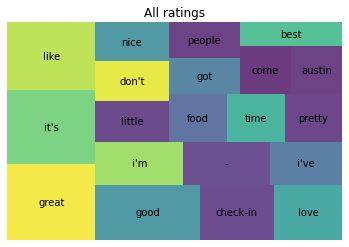

In [99]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.title('All ratings')
plt.show()

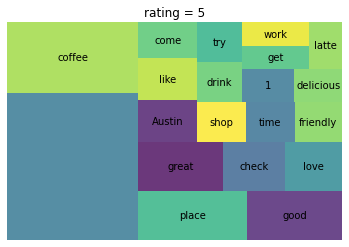

In [101]:
# rating = 5

shops_5 = shops.loc[shops['star_rating'] == 5.0] 

wc_5 = count(shops_5['lemmas']) 
wc_5_top20 = wc_5[wc_5['rank'] <= 20]

squarify.plot(sizes=wc_5_top20['pct_total'], label=wc_5_top20['word'], alpha=.8 )
plt.axis('off')
plt.title('rating = 5')
plt.show()

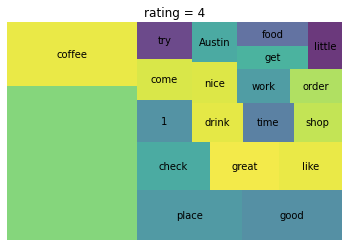

In [102]:
# rating = 4

shops_5 = shops.loc[shops['star_rating'] == 4.0] 

wc_5 = count(shops_5['lemmas']) 
wc_5_top20 = wc_5[wc_5['rank'] <= 20]

squarify.plot(sizes=wc_5_top20['pct_total'], label=wc_5_top20['word'], alpha=.8 )
plt.axis('off')
plt.title('rating = 4')
plt.show()

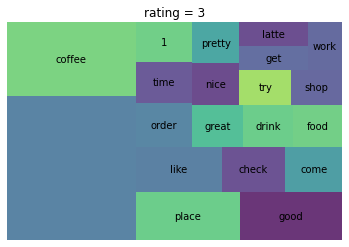

In [103]:
# rating = 3

shops_5 = shops.loc[shops['star_rating'] == 3.0] 

wc_5 = count(shops_5['lemmas']) 
wc_5_top20 = wc_5[wc_5['rank'] <= 20]

squarify.plot(sizes=wc_5_top20['pct_total'], label=wc_5_top20['word'], alpha=.8 )
plt.axis('off')
plt.title('rating = 3')
plt.show()

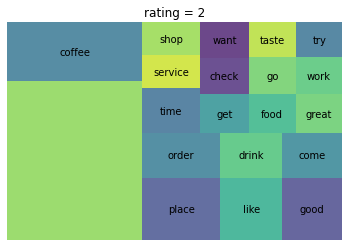

In [104]:
# rating = 2

shops_5 = shops.loc[shops['star_rating'] == 2.0] 

wc_5 = count(shops_5['lemmas']) 
wc_5_top20 = wc_5[wc_5['rank'] <= 20]

squarify.plot(sizes=wc_5_top20['pct_total'], label=wc_5_top20['word'], alpha=.8 )
plt.axis('off')
plt.title('rating = 2')
plt.show()

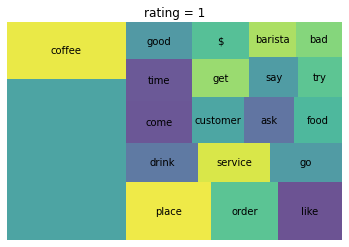

In [105]:
# rating = 1

shops_5 = shops.loc[shops['star_rating'] == 1.0] 

wc_5 = count(shops_5['lemmas']) 
wc_5_top20 = wc_5[wc_5['rank'] <= 20]

squarify.plot(sizes=wc_5_top20['pct_total'], label=wc_5_top20['word'], alpha=.8 )
plt.axis('off')
plt.title('rating = 1')
plt.show()

In [55]:
# see rating counts
shops['star_rating'].value_counts()

5.0    3780
4.0    2360
3.0     738
2.0     460
1.0     278
Name: star_rating, dtype: int64

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

